In [1]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,resnet34
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pickle
%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
is_cuda

True

## 유틸리티 함수

In [3]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)
    
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)
    
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target, reduction='sum').data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

## PyTorch 데이터셋 생성

In [4]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
# For Dogs & Cats dataset
train_dset = ImageFolder('./images/dogs-vs-cats/train/',transform=data_transform)
val_dset = ImageFolder('./images/dogs-vs-cats/valid/',transform=data_transform)
classes=2

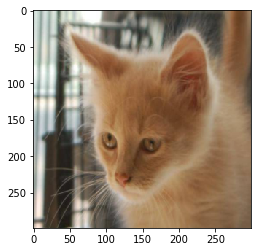

In [6]:
imshow(train_dset[150][0])

## 학습과 검증 데이터셋을 위한 데이터 로더 생성

In [7]:
train_loader = DataLoader(train_dset, batch_size=32, shuffle=False, num_workers=3)
val_loader = DataLoader(val_dset, batch_size=32, shuffle=False, num_workers=3)

## ResNet 34 모델 생성

In [8]:
my_resnet = resnet34(pretrained=True)

if is_cuda:
    my_resnet = my_resnet.cuda()

In [9]:
m = nn.Sequential(*list(my_resnet.children())[:-1])

## 컨볼루션 피처 추출

In [10]:
#For training data

# Stores the labels of the train data
trn_labels = [] 

# Stores the pre convoluted features of the train data
trn_features = [] 

#Iterate through the train data and store the calculated features and the labels
for d,la in train_loader:
    o = m(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    trn_labels.extend(la)
    trn_features.extend(o.cpu().data)

#For validation data

#Iterate through the validation data and store the calculated features and the labels
val_labels = []
val_features = []
for d,la in val_loader:
    o = m(Variable(d.cuda()))
    o = o.view(o.size(0),-1)
    val_labels.extend(la)
    val_features.extend(o.cpu().data)

## 학습과 검증 피처 데이터셋 생성

In [11]:
#Creating dataset for train and validation
trn_feat_dset = FeaturesDataset(trn_features,trn_labels)
val_feat_dset = FeaturesDataset(val_features,val_labels)

#Creating data loader for train and validation
trn_feat_loader = DataLoader(trn_feat_dset, batch_size=64, shuffle=True)
val_feat_loader = DataLoader(val_feat_dset, batch_size=64)

## 전연결 네트워크

In [12]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self,in_size,out_size):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = self.fc(inp)
        return out

In [13]:
fc_in_size = 8192

In [14]:
fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.cuda()

In [15]:
optimizer = optim.Adam(fc.parameters(),lr=0.0001)

## 학습과 검증 모델

In [16]:
train_losses, train_accuracy = [],[]
val_losses, val_accuracy = [],[]
for epoch in range(1,5):
    epoch_loss, epoch_accuracy = fit(epoch, fc, trn_feat_loader, phase='training')
    val_epoch_loss, val_epoch_accuracy = fit(epoch, fc, val_feat_loader, phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.53 and training accuracy is 17139/23000     74.52
validation loss is  0.45 and validation accuracy is 1604/2000      80.2
training loss is  0.37 and training accuracy is 19709/23000     85.69
validation loss is  0.33 and validation accuracy is 1763/2000     88.15
training loss is   0.3 and training accuracy is 20564/23000     89.41
validation loss is  0.29 and validation accuracy is 1804/2000      90.2
training loss is  0.26 and training accuracy is 20985/23000     91.24
validation loss is  0.25 and validation accuracy is 1824/2000      91.2


In [17]:
for epoch in range(1,5):
    epoch_loss, epoch_accuracy = fit(epoch, fc, trn_feat_loader, phase='training')
    val_epoch_loss, val_epoch_accuracy = fit(epoch, fc, val_feat_loader, phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.23 and training accuracy is 21290/23000     92.57
validation loss is  0.23 and validation accuracy is 1829/2000     91.45
training loss is  0.21 and training accuracy is 21495/23000     93.46
validation loss is  0.22 and validation accuracy is 1858/2000      92.9
training loss is   0.2 and training accuracy is 21629/23000     94.04
validation loss is   0.2 and validation accuracy is 1870/2000      93.5
training loss is  0.18 and training accuracy is 21772/23000     94.66
validation loss is  0.19 and validation accuracy is 1880/2000      94.0


In [18]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.17 and training accuracy is 21855/23000     95.02
validation loss is  0.18 and validation accuracy is 1881/2000     94.05
training loss is  0.16 and training accuracy is 21943/23000      95.4
validation loss is  0.18 and validation accuracy is 1868/2000      93.4
training loss is  0.15 and training accuracy is 21957/23000     95.47
validation loss is  0.17 and validation accuracy is 1897/2000     94.85
training loss is  0.14 and training accuracy is 22026/23000     95.77
validation loss is  0.16 and validation accuracy is 1903/2000     95.15
training loss is  0.14 and training accuracy is 22095/23000     96.07
validation loss is  0.15 and validation accuracy is 1896/2000      94.8
training loss is  0.13 and training accuracy is 22139/23000     96.26
validation loss is  0.15 and validation accuracy is 1906/2000      95.3
training loss is  0.12 and training accuracy is 22164/23000     96.37
validation loss is  0.15 and validation accuracy is 1902/2000      95.1
traini